In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# PSO

In [25]:
# Load existing traffic data
data = pd.read_csv('data.csv')

# Generate synthetic pedestrian flow rates and crossing times
np.random.seed(42)  # For reproducibility
pedestrian_flow_rate = np.random.uniform(20, 100, size=len(data))  # pedestrians per minute
pedestrian_crossing_time = np.random.uniform(10, 20, size=len(data))  # crossing time in seconds

# Add new columns to the dataset
data['pedestrian_flow_rate'] = pedestrian_flow_rate
data['pedestrian_crossing_time'] = pedestrian_crossing_time

# Save the updated dataset
data.to_csv('data_with_pedestrians.csv', index=False)

print(data.head())  


   Unnamed: 0  no_of_vehicle  avg_speed  avg_distance_btw_them  \
0           0             88         72                     77   
1           1             67         78                     91   
2           2             91         33                     37   
3           3             65         61                     35   
4           4             66         71                     32   

   pedestrian_flow_rate  pedestrian_crossing_time  
0             49.963210                 16.075449  
1             96.057145                 11.705241  
2             78.559515                 10.650516  
3             67.892679                 19.488855  
4             32.481491                 19.656320  


In [29]:
data

,Unnamed: 0,no_of_vehicle,avg_speed,avg_distance_btw_them,pedestrian_flow_rate,pedestrian_crossing_time
0,0,88,72,77,49.963210,16.075449
1,1,67,78,91,96.057145,11.705241
2,2,91,33,37,78.559515,10.650516
3,3,65,61,35,67.892679,19.488855
4,4,66,71,32,32.481491,19.656320
5,5,53,85,62,32.479562,18.083973
6,6,76,72,68,24.646689,13.046138
7,7,61,49,66,89.294092,10.976721
8,8,34,74,64,68.089201,16.842330
9,9,31,76,83,76.645806,14.401525


In [30]:
def simulate_traffic(green_times, total_time=300, traffic_arrival_rates=None, lane_capacity=1, 
                     pedestrian_flow_rate=None, pedestrian_crossing_time=None):
    num_signals = len(green_times)
    vehicles_waiting = np.zeros(num_signals)
    pedestrians_waiting = np.zeros(num_signals)
    total_waiting_time = 0

    for t in range(total_time):
        for i in range(num_signals):
            # Simulate vehicle arrivals
            arrivals = np.random.poisson(traffic_arrival_rates[i])
            vehicles_waiting[i] += arrivals
            
            # Simulate pedestrian arrivals
            pedestrian_arrivals = np.random.poisson(pedestrian_flow_rate[i] / 60)
            pedestrians_waiting[i] += pedestrian_arrivals
            
            # Green light for vehicles
            if t % sum(green_times) < green_times[i]:
                vehicles_passing = min(vehicles_waiting[i], lane_capacity)
                vehicles_waiting[i] -= vehicles_passing
            
            # Green light for pedestrians
            if t % sum(green_times) < pedestrian_crossing_time[i]:
                pedestrians_crossing = min(pedestrians_waiting[i], pedestrian_flow_rate[i] / 60)
                pedestrians_waiting[i] -= pedestrians_crossing
            
            #  waiting time
            total_waiting_time += vehicles_waiting[i] + pedestrians_waiting[i]

    return total_waiting_time


In [31]:

# Normalize avg_speed and avg_distance_btw_them to create traffic_arrival_rates
normalized_speed = (data['avg_speed'] - data['avg_speed'].min()) / (data['avg_speed'].max() - data['avg_speed'].min())
normalized_distance = (data['avg_distance_btw_them'] - data['avg_distance_btw_them'].min()) / (data['avg_distance_btw_them'].max() - data['avg_distance_btw_them'].min())

# Normalize pedestrian arrival rates similarly to traffic arrival rates
normalized_pedestrian_arrival = (data['pedestrian_flow_rate'] - data['pedestrian_flow_rate'].min()) / (data['pedestrian_flow_rate'].max() - data['pedestrian_flow_rate'].min())
traffic_arrival_rates = 1 - (normalized_speed + normalized_distance) / 2
traffic_arrival_rates = traffic_arrival_rates[:4]  

pedestrian_arrival_rates = normalized_pedestrian_arrival[:4]

pedestrian_crossing_time = data['pedestrian_crossing_time'].values[:4]


# PSO implementation using this simulation
num_particles = 30
num_iterations = 100
num_signals = len(traffic_arrival_rates)

best_fitness_per_iteration=[]  #to store results

w = 0.5
c1 = 1.5
c2 = 2.0

positions = np.random.uniform(10, 60, (num_particles, num_signals))
velocities = np.random.uniform(-1, 1, (num_particles, num_signals))


# Inside fitness_function
def fitness_function(signal_timings):
    min_green_time = 10
    max_green_time = 60
    max_cycle_length = 180  # Total time for one full cycle of lights

    if np.any(signal_timings < min_green_time) or np.any(signal_timings > max_green_time):
        return float('inf')  # Invalid signal timings
    
    if np.sum(signal_timings) > max_cycle_length:
        return float('inf')  # Invalid signal timings

    pedestrian_green_time = 10
    
    waiting_time = simulate_traffic(
        green_times=signal_timings,
        traffic_arrival_rates=traffic_arrival_rates,  
        pedestrian_flow_rate=pedestrian_arrival_rates,  
        pedestrian_crossing_time=pedestrian_crossing_time 
    )
    return waiting_time



personal_best_positions = positions.copy()
personal_best_scores = np.array([fitness_function(p) for p in positions])
global_best_position = personal_best_positions[np.argmin(personal_best_scores)]

# PSO main loop
for iteration in range(num_iterations):
    for i in range(num_particles):
        velocities[i] = (w * velocities[i] +
                         c1 * np.random.random() * (personal_best_positions[i] - positions[i]) +
                         c2 * np.random.random() * (global_best_position - positions[i]))
        
        positions[i] += velocities[i]
        positions[i] = np.clip(positions[i], 10, 60)
        
        current_fitness = fitness_function(positions[i])
        
        if current_fitness < personal_best_scores[i]:
            personal_best_scores[i] = current_fitness
            personal_best_positions[i] = positions[i]
    
    global_best_position = personal_best_positions[np.argmin(personal_best_scores)]
    best_fitness_per_iteration.append(min(personal_best_scores))
    print(f"Iteration {iteration}: Best Fitness = {min(personal_best_scores)}")

optimal_signal_timings = global_best_position
print("Optimal Signal Timings:", optimal_signal_timings)

Iteration 0: Best Fitness = 51223.55899847273
Iteration 1: Best Fitness = 49264.24833468166
Iteration 2: Best Fitness = 49264.24833468166
Iteration 3: Best Fitness = 49264.24833468166
Iteration 4: Best Fitness = 49264.24833468166
Iteration 5: Best Fitness = 49264.24833468166
Iteration 6: Best Fitness = 49264.24833468166
Iteration 7: Best Fitness = 49264.24833468166
Iteration 8: Best Fitness = 49264.24833468166
Iteration 9: Best Fitness = 49264.24833468166
Iteration 10: Best Fitness = 49264.24833468166
Iteration 11: Best Fitness = 49264.24833468166
Iteration 12: Best Fitness = 49264.24833468166
Iteration 13: Best Fitness = 49264.24833468166
Iteration 14: Best Fitness = 49264.24833468166
Iteration 15: Best Fitness = 49264.24833468166
Iteration 16: Best Fitness = 49264.24833468166
Iteration 17: Best Fitness = 49264.24833468166
Iteration 18: Best Fitness = 49264.24833468166
Iteration 19: Best Fitness = 49264.24833468166
Iteration 20: Best Fitness = 49264.24833468166
Iteration 21: Best Fitn

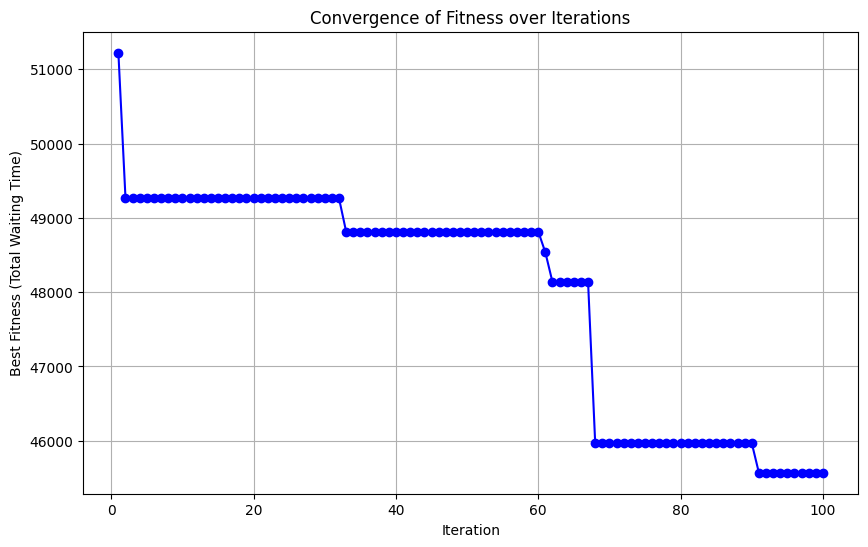

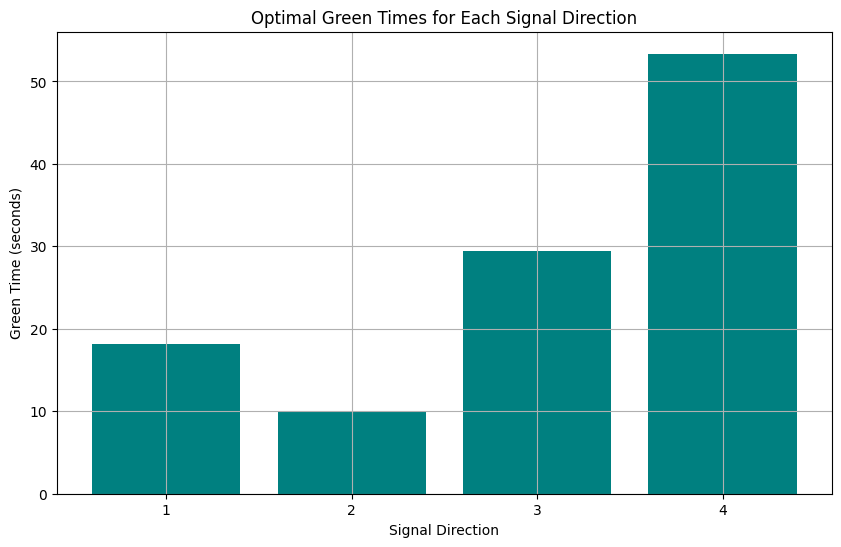

In [32]:

# Visualization 1: Convergence of Fitness
plt.figure(figsize=(10, 6))
iterations = np.arange(1, num_iterations + 1)
plt.plot(iterations, best_fitness_per_iteration, marker='o', color='blue')
plt.title("Convergence of Fitness over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Best Fitness (Total Waiting Time)")
plt.grid(True)
plt.show()

# Visualization 2: Optimal Signal Timings
plt.figure(figsize=(10, 6))
num_signals = len(optimal_signal_timings)
signal_directions = np.arange(1, num_signals + 1)
plt.bar(signal_directions, optimal_signal_timings, color='teal')
plt.title("Optimal Green Times for Each Signal Direction")
plt.xlabel("Signal Direction")
plt.ylabel("Green Time (seconds)")
plt.xticks(signal_directions)
plt.grid(True)
plt.show()


# Genetic Algorithm

In [34]:

# Define GA parameters
population_size = 50
num_generations = 100
num_signals = 4  # 4 directions 
mutation_rate = 0.1

# Initialize population with random signal timings
population = np.random.uniform(10, 60, (population_size, num_signals))

# Lists to store best fitness and optimal timings over generations
best_fitness_list = []
optimal_signal_timings_list = []

# Define the fitness function
def fitness_function(signal_timings):
    min_green_time = 10
    max_green_time = 60
    max_cycle_length = 180  # Total time for one full cycle of lights

    if np.any(signal_timings < min_green_time) or np.any(signal_timings > max_green_time):
        return float('inf')  # Invalid signal timings

    if np.sum(signal_timings) > max_cycle_length:
        return float('inf')  # Invalid signal timings

    waiting_time = simulate_traffic(
        green_times=signal_timings,
        traffic_arrival_rates=traffic_arrival_rates,  
        pedestrian_flow_rate=pedestrian_arrival_rates, 
        pedestrian_crossing_time=pedestrian_crossing_time  
    )
    return waiting_time

# Selection: Roulette Wheel Selection
def select_parents(population, fitness):
    fitness = 1 / (1 + fitness)  # Convert waiting time to a "higher is better" fitness score
    total_fitness = np.sum(fitness)
    selection_probs = fitness / total_fitness
    parents_indices = np.random.choice(range(population_size), size=2, p=selection_probs)
    return population[parents_indices]

# Crossover: Single-point crossover
def crossover(parents):
    crossover_point = np.random.randint(1, num_signals)
    child1 = np.concatenate((parents[0, :crossover_point], parents[1, crossover_point:]))
    child2 = np.concatenate((parents[1, :crossover_point], parents[0, crossover_point:]))
    return child1, child2

# Mutation: Randomly mutate a gene in the chromosome
def mutate(child):
    for i in range(num_signals):
        if np.random.rand() < mutation_rate:
            child[i] = np.random.uniform(10, 60)  # Reassign a random green time within the range
    return child

# GA main loop
for generation in range(num_generations):
    # Evaluate fitness for the current population
    fitness_scores = np.array([fitness_function(p) for p in population])
    
    # Create a new population
    new_population = []
    for _ in range(population_size // 2):  # Create population_size children
        parents = select_parents(population, fitness_scores)
        child1, child2 = crossover(parents)
        new_population.extend([mutate(child1), mutate(child2)])
    
    population = np.array(new_population)

    # Track the best fitness and optimal signal timings for the current generation
    best_fitness_idx = np.argmin(fitness_scores)
    best_fitness = fitness_scores[best_fitness_idx]
    best_signal_timings = population[best_fitness_idx]
    
    best_fitness_list.append(best_fitness)
    optimal_signal_timings_list.append(best_signal_timings)
    print(f"Generation {generation}: Best Fitness = {fitness_scores[best_fitness_idx]}")
    
# Best signal timings found
optimal_signal_timings_ga = population[np.argmin(fitness_scores)]
print("Optimal Signal Timings (GA):", optimal_signal_timings_ga)


Generation 0: Best Fitness = 51422.091869019816
Generation 1: Best Fitness = 53003.97849969278
Generation 2: Best Fitness = 55360.61456440666
Generation 3: Best Fitness = 53383.61111072809
Generation 4: Best Fitness = 51981.320292335484
Generation 5: Best Fitness = 54872.52799013875
Generation 6: Best Fitness = 47926.27571167352
Generation 7: Best Fitness = 53013.730864703946
Generation 8: Best Fitness = 53559.048082943526
Generation 9: Best Fitness = 52100.33470293075
Generation 10: Best Fitness = 47393.009417208414
Generation 11: Best Fitness = 55300.98481039554
Generation 12: Best Fitness = 50700.473077759074
Generation 13: Best Fitness = 54333.537566933606
Generation 14: Best Fitness = 52921.3609350422
Generation 15: Best Fitness = 52744.80366881355
Generation 16: Best Fitness = 54539.44663724484
Generation 17: Best Fitness = 50032.28283701608
Generation 18: Best Fitness = 54964.4982304337
Generation 19: Best Fitness = 53374.43793262552
Generation 20: Best Fitness = 51348.563603124

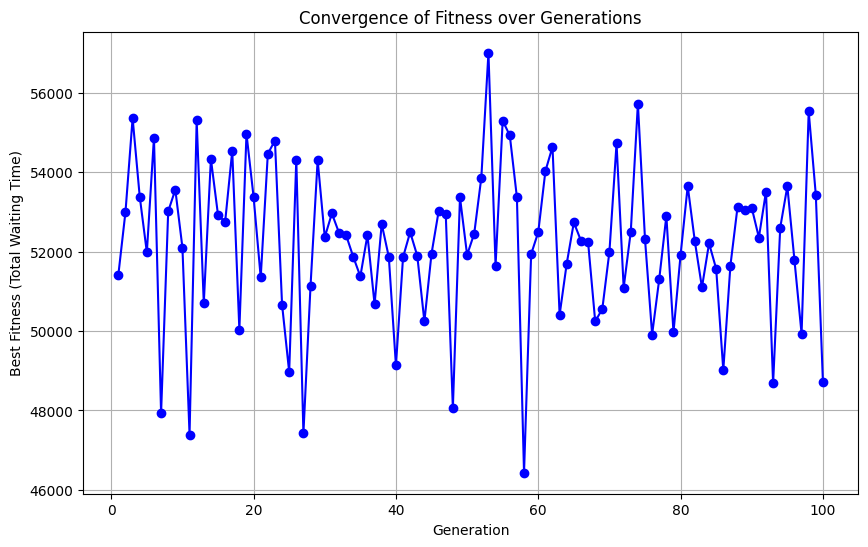

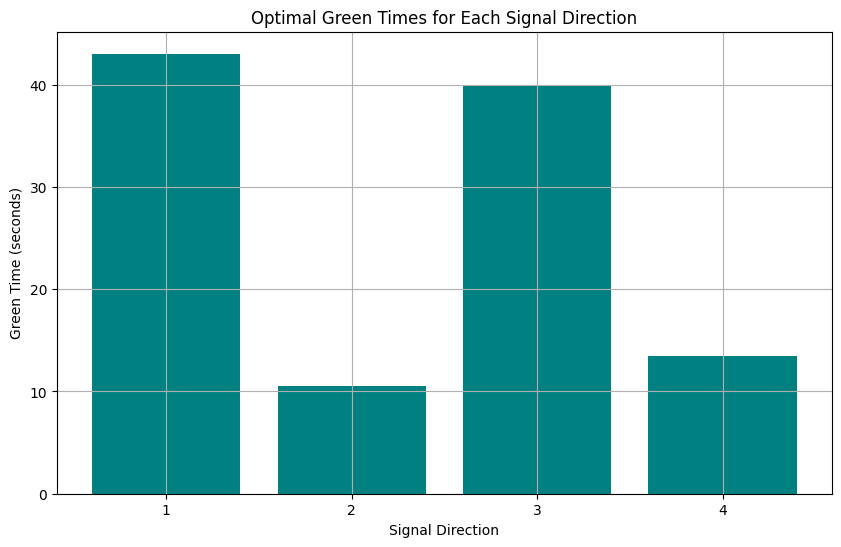

In [36]:
# Visualization

# 1. Convergence of Fitness over Generations
plt.figure(figsize=(10, 6))
generations = np.arange(1, num_generations + 1)
plt.plot(generations, best_fitness_list, marker='o', color='blue')
plt.title("Convergence of Fitness over Generations")
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Total Waiting Time)")
plt.grid(True)
plt.show()

# 2. Optimal Signal Timings
plt.figure(figsize=(10, 6))
signal_directions = np.arange(1, num_signals + 1)
plt.bar(signal_directions, optimal_signal_timings_ga, color='teal')
plt.title("Optimal Green Times for Each Signal Direction")
plt.xlabel("Signal Direction")
plt.ylabel("Green Time (seconds)")
plt.xticks(signal_directions)
plt.grid(True)
plt.show()

# Simulated Annealing

In [38]:
# Extract necessary columns
traffic_arrival_rates = data['no_of_vehicle'].values / 300  # vehicles per second over 5 minutes
pedestrian_flow_rate = data['pedestrian_flow_rate'].values  # pedestrians per minute
pedestrian_crossing_time = data['pedestrian_crossing_time'].values  # pedestrian crossing time in seconds

# Assume lane_capacity and total_time for simulation
lane_capacity = 5  # Example lane capacity
total_time = 300 

In [47]:
def fitness_function(signal_timings):
    waiting_time = simulate_traffic(
        green_times=signal_timings,
        total_time=total_time,
        traffic_arrival_rates=traffic_arrival_rates,
        lane_capacity=lane_capacity,
        pedestrian_flow_rate=pedestrian_flow_rate,
        pedestrian_crossing_time=pedestrian_crossing_time
    )
    return waiting_time

def simulated_annealing(initial_solution, max_iter=100, initial_temp=100, cooling_rate=0.95):
    current_solution = initial_solution.copy()
    current_fitness = fitness_function(current_solution)
    best_solution = current_solution.copy()
    best_fitness = current_fitness
    temperature = initial_temp

    # Track fitness over iterations for analysis
    fitness_history = []

    for i in range(max_iter):
        # Generate a new solution
        perturbation = np.random.uniform(-2, 2, size=len(current_solution))  # Smaller perturbation range
        new_solution = current_solution + perturbation
        new_solution = np.clip(new_solution, 10, 60)  # Ensure timings are within bounds
        
        # Calculate the fitness of the new solution
        new_fitness = fitness_function(new_solution)
        
        # Calculate the acceptance probability
        acceptance_probability = np.exp((current_fitness - new_fitness) / temperature)
        
        # Accept the new solution
        if new_fitness < current_fitness or np.random.rand() < acceptance_probability:
            current_solution = new_solution
            current_fitness = new_fitness
            
            # Update the best solution found
            if current_fitness < best_fitness:
                best_solution = current_solution
                best_fitness = current_fitness
        
        # Cool down the temperature
        temperature *= cooling_rate
        
        # Record fitness history
        fitness_history.append(best_fitness)
        
        # Print iteration details
        if i % 10 == 0:  # Print every 10 iterations
            print(f"Iteration {i}: Best Fitness = {best_fitness}, Temperature = {temperature}")
    
    return best_solution, best_fitness, fitness_history

initial_solution = np.random.uniform(10, 60, 4)  # 4 signal directions

# Run Simulated Annealing
optimal_signal_timings_sa, best_fitness_sa, fitness_history = simulated_annealing(initial_solution)
print("Optimal Signal Timings (SA):", optimal_signal_timings_sa)
print("Best Fitness (SA):", best_fitness_sa)


Iteration 0: Best Fitness = 201285.53093307032, Temperature = 95.0
Iteration 10: Best Fitness = 192313.71723070304, Temperature = 56.880009227645964
Iteration 20: Best Fitness = 192313.71723070304, Temperature = 34.05616262881148
Iteration 30: Best Fitness = 192313.71723070304, Temperature = 20.390682574579035
Iteration 40: Best Fitness = 192313.71723070304, Temperature = 12.208654873684791
Iteration 50: Best Fitness = 192313.71723070304, Temperature = 7.309772651287744
Iteration 60: Best Fitness = 192313.71723070304, Temperature = 4.376630903760432
Iteration 70: Best Fitness = 192313.71723070304, Temperature = 2.620450591493621
Iteration 80: Best Fitness = 190494.26229981234, Temperature = 1.5689605665762896
Iteration 90: Best Fitness = 190494.26229981234, Temperature = 0.9393946474176
Optimal Signal Timings (SA): [46.24149625 42.12149673 43.44818218 35.00315332]
Best Fitness (SA): 190494.26229981234


/var/folders/36/11dhy8pn2gb_w904ysmkk2h80000gn/T/ipykernel_50993/986991287.py:44: RuntimeWarning: overflow encountered in exp
  acceptance_probability = np.exp((current_fitness - new_fitness) / temperature)


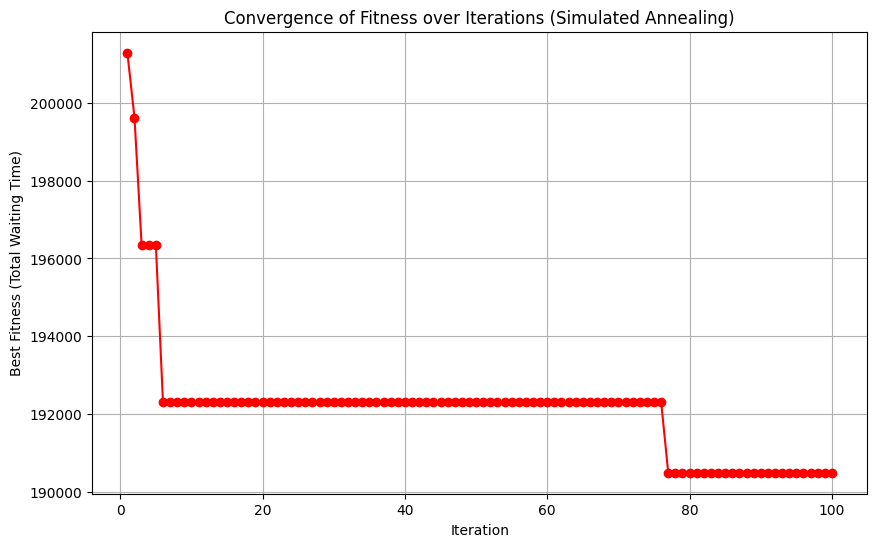

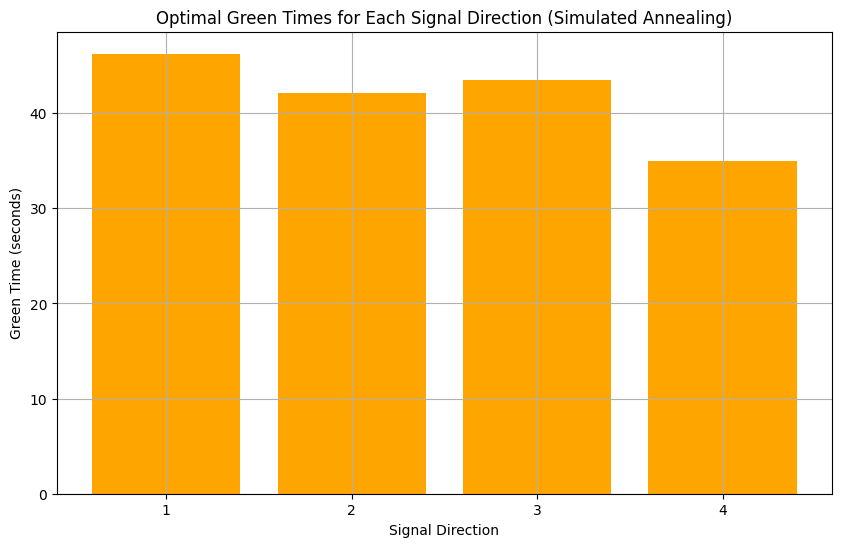

In [48]:
# Visualization 1: Convergence of Fitness
plt.figure(figsize=(10, 6))
iterations = np.arange(1, len(fitness_history) + 1)
plt.plot(iterations, fitness_history, marker='o', color='red')
plt.title("Convergence of Fitness over Iterations (Simulated Annealing)")
plt.xlabel("Iteration")
plt.ylabel("Best Fitness (Total Waiting Time)")
plt.grid(True)
plt.show()

# Visualization 2: Optimal Signal Timings
plt.figure(figsize=(10, 6))
num_signals = len(optimal_signal_timings_sa)
signal_directions = np.arange(1, num_signals + 1)
plt.bar(signal_directions, optimal_signal_timings_sa, color='orange')
plt.title("Optimal Green Times for Each Signal Direction (Simulated Annealing)")
plt.xlabel("Signal Direction")
plt.ylabel("Green Time (seconds)")
plt.xticks(signal_directions)
plt.grid(True)
plt.show()
